# Assignment 2

In [42]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from prettytable import PrettyTable
import locale

In [43]:
# Setting Locale for Daniel
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

In [44]:
with open("data/spx.csv", "r") as file:
    sp_raw = pd.read_csv(file, delimiter=",")
    
sp_raw.head()


,Date,Close/Last,Open,High,Low
0,02/28/2025,5954.50,5856.74,5959.40,5837.66
1,02/27/2025,5861.57,5981.88,5993.69,5858.78
2,02/26/2025,5956.06,5970.87,6009.82,5932.69
3,02/25/2025,5955.25,5982.73,5992.65,5908.49
4,02/24/2025,5983.25,6026.69,6043.65,5977.83


In [45]:
with open("data/ethereum.xlsx", "rb") as file:
    eth_raw = pd.read_excel(file, header=None, sheet_name="Data", usecols="B:C", names=["Date", "Price"], skiprows=5)

eth_raw

,Date,Price
0,"Jun 7, 2022",1814.05
1,"Jun 8, 2022",1793.57
2,"Jun 9, 2022",1789.83
3,"Jun 10, 2022",1665.04
4,"Jun 11, 2022",1529.66
...,...,...
995,"Feb 26, 2025",2331.45
996,"Feb 27, 2025",2305.48
997,"Feb 28, 2025",2237.91
998,"Mar 1, 2025",2216.64


In [46]:
# Data Cleaning

## Convert month names to German readable format
sp_clean = sp_raw.copy()
eth_clean = eth_raw.copy()

## Date Format
eth_clean["Date"] = pd.to_datetime(eth_raw["Date"])
sp_clean["Date"] = pd.to_datetime(sp_raw["Date"])

## restrict data to Jun 2022 and Feb 28, 2025
sp_clean = sp_clean[(sp_clean["Date"] >= "2022-06-07") & (sp_clean["Date"] <= "2025-02-28")]
eth_clean = eth_clean[(eth_clean["Date"] >= "2022-06-07") & (eth_clean["Date"] <= "2025-02-28")]

In [ ]:
def summarize_data(data, len_period):
    '''
        Returnes DF with rolling time horizons
        data: DataFrame
        len_period: int
    '''
    def calculate_ROI(start, end): 
        return (end-start)/start * 100
    
    def calculate_Volatility(data):
        return data.std()/data.mean() * 100
    
    rolling_period = data.rolling(len_period)
    print(rolling_period)
    ROI = rolling_period.apply(lambda x: calculate_ROI(x.iloc[0], x.iloc[-1]))
    volatility = rolling_period.apply(lambda x: calculate_Volatility(x))
    
    return (ROI, volatility)


def plot_summary_data(data1, data2, title, xlabel, ylabel):
    '''
        Plots the data
        data: DataFrame
        title: str
        xlabel: str
        ylabel: str
    '''
    data1.plot()
    
    plt.title(title)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def table_summary_data(data1, data2, period):
    '''
        Returns a table with the data
        data1: DataFrame
        period: int
        data2: DataFrame
    '''
    # Create a PrettyTable object
    table = PrettyTable()
    table.field_names = ["Period", "Metric", "Value"]
    for i in range(period - 1, len(data1)):
        table.add_row([i, data1[i], data2[i]])


    # Print the table
    print(table)
    

Rolling [window=30,center=False,axis=0,method=single]


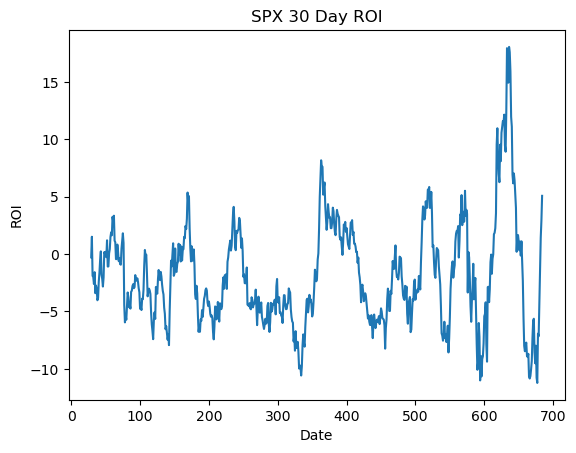

In [64]:
ROI_30, volatility_30 = summarize_data(sp_clean["Close/Last"], 30)
plot_data(ROI_30, "SPX 30 Day ROI", "Date", "ROI")
